In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tqdm import tqdm
import os
import cv2
from sklearn.model_selection import train_test_split

# Image Processing

In [2]:
# Input Folders
main_folder = 'dataset/traffic_object_detection'
train_folder = f'{main_folder}/train'
test_folder = f'{main_folder}/test'
valid_folder = f'{main_folder}/valid'

# Output Folders
output_folder = 'dataset/traffic_object_detection_processed'
output_train_folder = f'{output_folder}/train'
output_test_folder = f'{output_folder}/test'
output_valid_folder = f'{output_folder}/valid'

classes = ['bicycle', 'bus', 'car', 'motorbike', 'person']
colors = [[0, 255, 0], [255, 0, 0], [0, 255, 0], [200, 200, 0], [200, 200, 200]]

In [64]:
def upscale_points(image, coordinates):
    x = int(coordinates[1] * image.shape[0])
    y = int(coordinates[2] * image.shape[1])
    width = int(coordinates[3] * image.shape[0])
    height = int(coordinates[4] * image.shape[1])
    return (int(coordinates[0]), y, x, height, width)

def draw_boundary(image, color, coordinates):
    (object_class, x, y, width, height) = upscale_points(image, coordinates)
    image[x-width:x+width, y-height:y-height+5, :] = color
    image[x+width:x+width+5, y-height:y+height, :] = color
    image[x-width:x+width, y+height-5:y+height, :] = color
    image[x-width-5:x-width, y-height:y+height, :] = color
    return image, (int(coordinates[0]), x, y, width, height)

def clip(value, prev_min, prev_max, new_min, new_max):
    return int((((value - prev_min) * (new_max - new_min)) / (prev_max - prev_min)) + new_min)

## Data Display

aguanambi-1085_png_jpg.rf.9560a8e9822039cd2b4566dd71f288a7.txt aguanambi-1085_png_jpg.rf.9560a8e9822039cd2b4566dd71f288a7.jpg


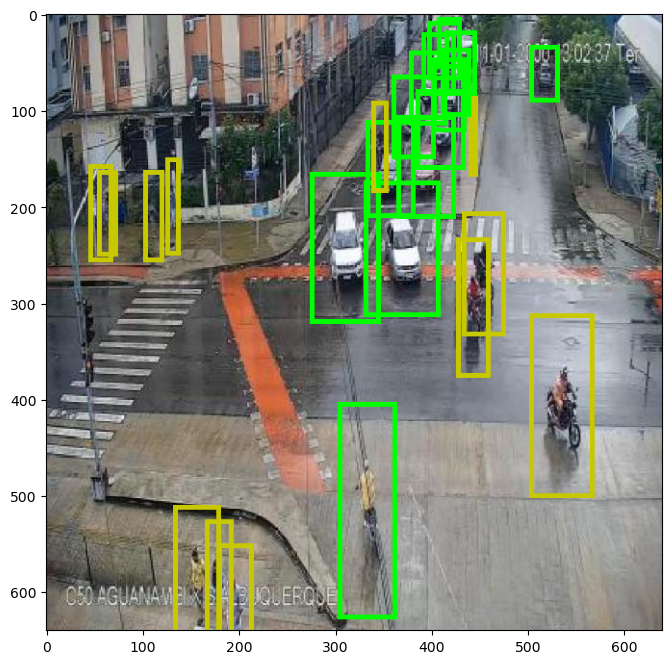

In [66]:
# Loading data
image_index = 4
images = os.listdir(f'{train_folder}/images')
labels = os.listdir(f'{train_folder}/labels')
image = plt.imread(f'{train_folder}/images/{images[image_index]}')
label = ''
object_coordinates = []
with open(f'{train_folder}/labels/{labels[image_index]}', 'r') as file:
    label = file.readlines()
new_image = image.copy()
for lab in label:
    coordinates = [float(num) for num in lab.split(' ')]
    new_image, coords = draw_boundary(new_image, colors[int(coordinates[0])], coordinates)
    object_coordinates.append(coords)

print(labels[image_index], images[image_index])

plt.figure(figsize=(8, 8))
plt.imshow(new_image)

In [67]:
def load_image(images, labels, index):
    image = plt.imread(f'{train_folder}/images/{images[index]}')
    image = cv2.resize(image, (640, 640))
    object_coordinates = []
    with open(f'{train_folder}/labels/{labels[index]}', 'r') as file:
        label = file.readlines()
    for lab in label:
        coordinates = [float(num) for num in lab.split(' ')]
        coords = upscale_points(image, coordinates)
        object_coordinates.append(coords)
    return image, object_coordinates


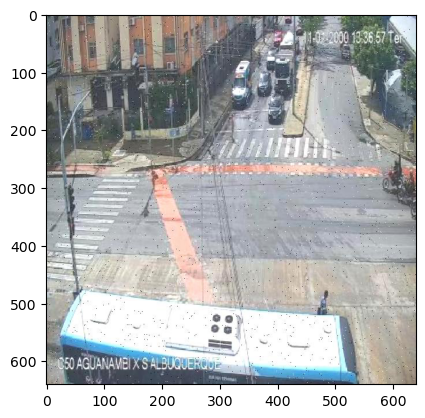

In [68]:
t_image, t_coords = load_image(images, labels, 500)
plt.imshow(t_image)

# Defining Data Generator

In [69]:
# Generates anchor points accross the image
def generate_anchor_points(image, stride = 5):
    anchor_points = []
    for i in range(stride, image.shape[0], stride):
        for j in range(stride, image.shape[1], stride):
            anchor_points.append([i, j])
    return anchor_points

def add_anchor_points(image, points, point_size = 5): 
    new_image = image.copy()
    for point in points:
        new_image[point[0] - point_size : point[0] + point_size, point[1] - point_size : point[1] + point_size, :] = [255, 255, 0]
    return new_image

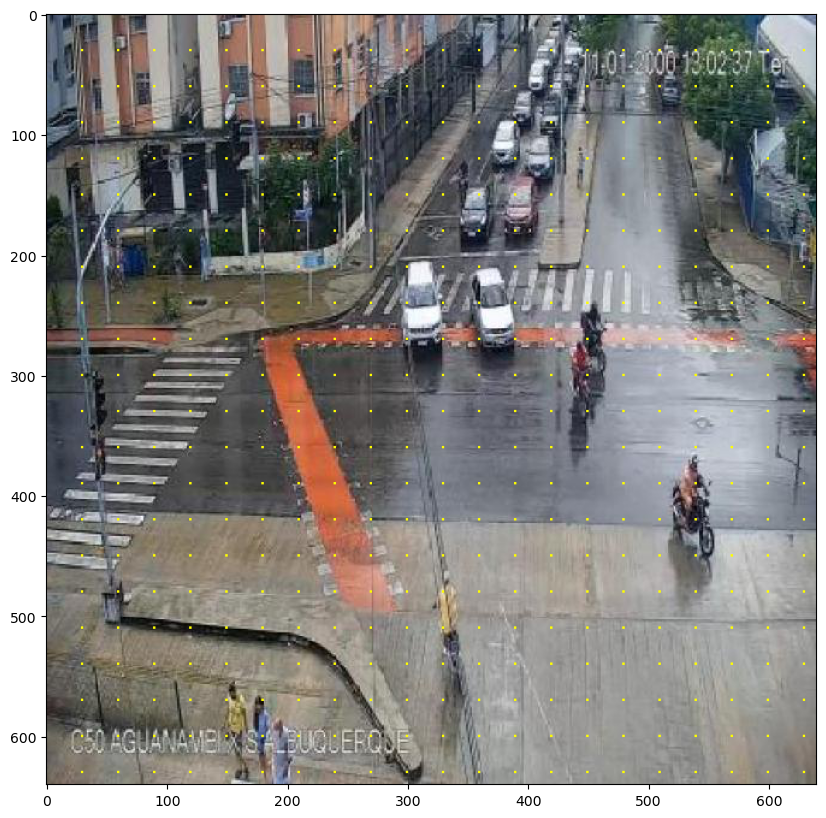

In [70]:
anchor_point_stride = 30
anchor_points = generate_anchor_points(image, anchor_point_stride)
anchor_points_image = add_anchor_points(image, anchor_points, 1)
plt.figure(figsize=(10, 10))
plt.imshow(anchor_points_image)

In [71]:
# The number of anchor points for an image
anchor_points.__len__(), ((image.shape[0] - anchor_point_stride) / anchor_point_stride) * ((image.shape[1] - anchor_point_stride) / anchor_point_stride)

(441, 413.4444444444444)

In [72]:
def generate_regions(anchor_points, region_ratios, region_scales):
    # Going for each anchor point
    regions = []
    for anchor in anchor_points:
        for ratio in region_ratios:
            for scale in region_scales:
                value = 1 * scale
                width = ratio[0] * value
                height = ratio[1] * value
                regions.append([anchor[0], anchor[1], width, height])
    return regions

def add_regions(image, regions, color=[0, 0, 0], thickness = 1):
    new_image = image.copy()
    index = 0
    for region in regions:
        x = region[0]
        y = region[1]
        width = region[2]
        height = region[3]
        topleft = [0 if x - width < 0 else x - width, 0 if y - height < 0 else y - height]
        topright = [image.shape[0] if x + width > image.shape[0] else  x + width, 0 if y - height < 0 else y - height]
        bottomleft = [0 if x - width < 0 else x - width, image.shape[1] if y + height > image.shape[1] else y + height]
        bottomright = [image.shape[0] if x + width > image.shape[0] else x + width, image.shape[1] if y + height > image.shape[1] else y + height]
        chosen_color = color[int(index / len(color))]
        index += 1
        new_image[topleft[0] : topright[0], topleft[1]:topleft[1] + thickness, :] = chosen_color
        new_image[topright[0]:topright[0] + thickness, topright[1]:bottomright[1], :] = chosen_color
        new_image[bottomleft[0] : bottomright[0], bottomleft[1] - thickness : bottomleft[1], :] = chosen_color
        new_image[bottomleft[0] - thickness : bottomleft[0], topleft[1]:bottomleft[1], :] = chosen_color
    return new_image

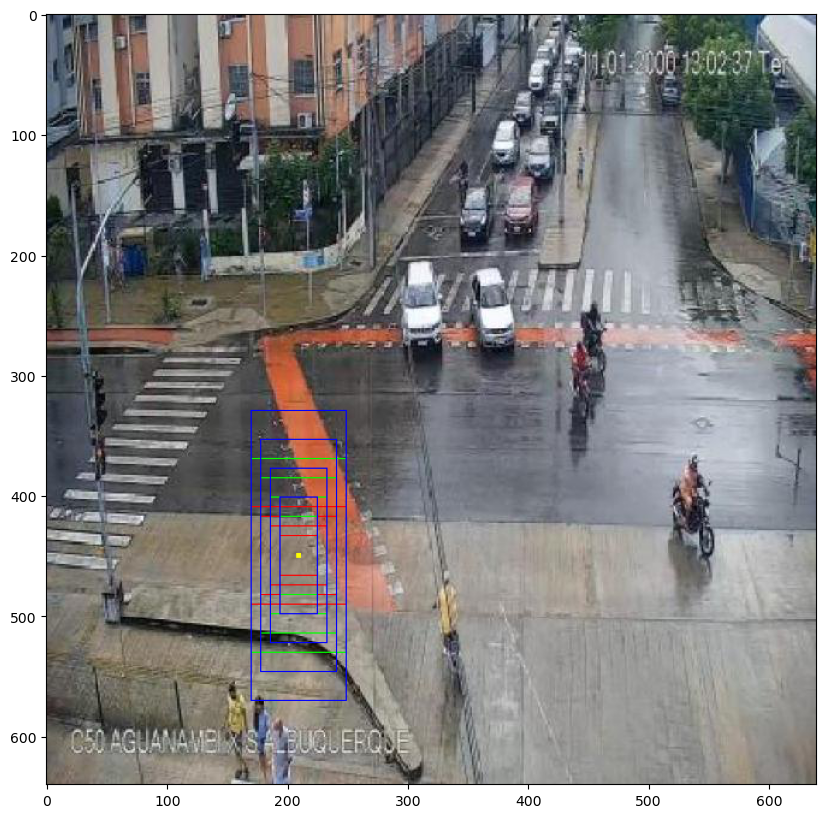

In [106]:
points = anchor_points
region_ratios = [[1, 1], [2, 1], [3, 1]]
region_scales = [16, 24, 32, 40]
regions = generate_regions(points, region_ratios, region_scales)

# Test Points
test_points = [points[300]]
test_regions = generate_regions(test_points, region_ratios, region_scales)
regioned_image = add_regions(image, test_regions, [[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0]], 1)
regioned_image = add_anchor_points(regioned_image, test_points, 2)
plt.figure(figsize=(10, 10))
plt.imshow(regioned_image)

In [107]:
print(f'Anchor Points: {len(anchor_points)}')
print(f'Regions: {len(regions)}')
print(f'Regions Calculation: {len(anchor_points) * len(region_ratios) * len(region_scales)}')

Anchor Points: 441
Regions: 5292
Regions Calculation: 5292


In [108]:
def overlapArea(rect1, rect2):

   # Finding the length and width of the overlap area
   x = max(0, min(rect1[2], rect2[2]) - max(rect1[0], rect2[0]))
   y = max(0, min(rect1[3], rect2[3]) - max(rect1[1], rect2[1]))
   area = x * y
   return area


In [167]:
# Generating Masks for each object in the image
def generate_masks(image, x, y, width, height):
    mask = np.zeros(image.shape)
    mask[x - width : x + width, y - height : y + height, :] = [1, 1, 1]
    return mask

# Checks whether the region goes out of the iamge at any side or not
def is_region_inside_image(image, region):
    x = region[0]
    y = region[1]
    width = region[2]
    height = region[3]

    if x - width < 0 or x + width > image.shape[0] or y - height < 0 or y + height > image.shape[1]:
        return False
    else:
        return True

def find_IOU(object_coords, target_region):
    a1 = (object_coords[3] * 2) * (object_coords[4] * 2)
    a2 = (target_region[2] * 2) * (target_region[3] * 2)
    rect1 = [object_coords[0] - object_coords[2], object_coords[1] - object_coords[3], object_coords[0] + object_coords[2], object_coords[1] + object_coords[3]]
    rect2 = [target_region[0] - target_region[2], target_region[1] - target_region[3], target_region[0] + target_region[2], target_region[1] + target_region[3]]
    # if object_coords[0] <= target_region[0] and object_coords[1] <= target_region[1]:
    #     point1 = (object_coords[0] + object_coords[2], object_coords[1] + object_coords[3])
    #     point2 = (target_region[0] - target_region[2], target_region[1] - target_region[3])
    #     intersection = [point1[0] - point2[0], point1[1] - point2[1]]
    # elif object_coords[0] <= target_region[0] and object_coords[1] >= target_region[1]:
    #     point1 = (object_coords[0] + object_coords[2], object_coords[1] - object_coords[3])
    #     point2 = (target_region[0] - target_region[2], target_region[1] + target_region[3])
    #     intersection = [point1[0] - point2[0], point2[1] - point1[1]]
    # elif object_coords[0] >= target_region[0] and object_coords[1] >= target_region[1]:
    #     point1 = (object_coords[0] - object_coords[2], object_coords[1] - object_coords[3])
    #     point2 = (target_region[0] + target_region[2], target_region[1] + target_region[3])
    #     intersection = [point2[0] - point1[0], point2[1] - point1[1]]
    # elif object_coords[0] >= target_region[0] and object_coords[1] <= target_region[1]:
    #     point1 = (object_coords[0] - object_coords[2], object_coords[1] + object_coords[3])
    #     point2 = (target_region[0] + target_region[2], target_region[1] - target_region[3])
    #     intersection = [point2[0] - point1[0], point1[1] - point2[1]]

    # if intersection[0] <= 0 or intersection[1] <= 0:
    #     intersection[0] = 0
    #     intersection[1] = 0
    intersection_area = overlapArea(rect1, rect2)
    # intersection_area = intersection[0] * intersection[1]
    total_area = a1 + a2 - intersection_area
    if intersection_area / total_area > 0.5:
        print(object_coords)
        print(target_region)
        print(intersection_area / total_area, a1, a2, intersection_area)
    return intersection_area / total_area

def show_overlapping_area(region_mask, object_mask):
    main_mask = region_mask
    main_mask[main_mask == 1] = 0.5
    object_mask = object_mask
    object_mask[object_mask == 1] = 0.5
    combined_mask = main_mask + object_mask
    return combined_mask

In [168]:
region_targets = []
for region in tqdm(regions):
    if is_region_inside_image(image, region):
        for object_coords in object_coordinates:
            iou = find_IOU(object_coords, region)
            if iou > 0.5 or (iou < 0.3 and iou > 0):
                region_targets.append([1 if iou > 0.5 else 0, iou, object_coords[0], region[0], region[1], region[2], region[3]])

 16%|█▋        | 863/5292 [00:00<00:00, 18189.37it/s]

(2, 71, 426, 31, 16)
[30, 30, 16, 16]
4.740458015267175 1984 1024 2484
(2, 84, 419, 34, 18)
[30, 30, 24, 24]
0.536869340232859 2448 2304 1660
(2, 77, 397, 34, 20)
[30, 30, 24, 24]
6.166904422253923 2720 2304 4323
(2, 107, 382, 39, 23)
[30, 60, 16, 16]
1.791767554479419 3588 1024 2960
(2, 52, 408, 28, 18)
[30, 90, 16, 16]
3.5783132530120483 2016 1024 2376
(2, 51, 431, 29, 17)
[30, 90, 16, 16]
5.215767634854772 1972 1024 2514
(2, 77, 397, 34, 20)
[30, 120, 16, 16]
2.569113441372736 2720 1024 2695
(2, 71, 426, 31, 16)
[30, 120, 24, 24]
1.4419134396355353 1984 2304 2532
(3, 200, 132, 46, 8)
[30, 150, 16, 16]
1.3908045977011494 1472 1024 1452
(2, 107, 382, 39, 23)
[30, 150, 16, 16]
25.813953488372093 3588 1024 4440
(3, 200, 132, 46, 8)
[30, 150, 24, 24]
2.157190635451505 1472 2304 2580
(3, 207, 64, 40, 11)
[30, 180, 16, 16]
1.2325581395348837 1760 1024 1537
(3, 207, 57, 46, 13)
[30, 180, 16, 16]
0.8914728682170543 2392 1024 1610
(2, 243, 311, 74, 37)
[30, 180, 16, 16]
2.0684089162182935 109

ZeroDivisionError: division by zero

In [150]:
def propose_regions(image, object_coordinates, anchor_point_stride = 20, region_ratios = [[1, 1], [2, 1], [3, 1]], region_scales = [16, 24, 32, 40], iou_limit = 0.5):

    # Generating masks
    masks = []
    for coords in object_coordinates:
        masks.append(generate_masks(image, coords[1], coords[2], coords[3], coords[4]))

    anchor_points = generate_anchor_points(image, anchor_point_stride)
    regions = generate_regions(anchor_points, region_ratios, region_scales)
    region_targets = []
    for region in tqdm(regions):
        if is_region_inside_image(image, region):
            for object_coords in object_coordinates:
                iou = find_IOU(object_coords, region)
                if iou > 0.5 or (iou < 0.3 and iou > 0):
                    region_targets.append([1 if iou > 0.5 else 0, iou, object_coords[0], region[0], region[1], region[2], region[3]])
    return region_targets

In [164]:
ious = [region[1] for region in region_targets]
max(ious)

10.590747330960854

In [152]:
count = 0
fine_regions = []
for i in range(0, len(region_targets)):
    if region_targets[i][0] == 1:
        count += 1
        fine_regions.append(region_targets[i])
count, len(region_targets)

(5713, 13413)

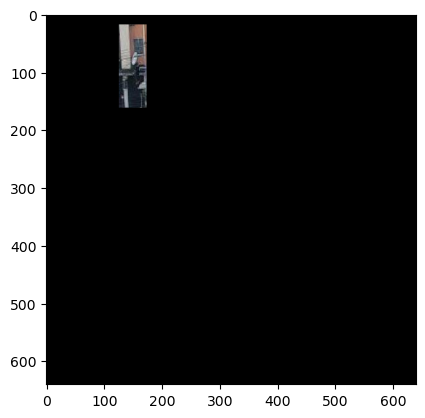

In [155]:
target = fine_regions
for i in range(550, len(target)):
    x = target[i][3]
    y = target[i][4]
    width = target[i][5]
    height=target[i][6]
    region_mask = generate_masks(image, x, y, width, height)
    new_image = image.copy()
    new_image[region_mask != 1] = 0
    plt.imshow(new_image)
    break

In [17]:
def resize_region(image, region, new_size = (64, 64)):
    x = region[3]
    y = region[4]
    width = region[5]
    height = region[6]
    cropped_image = image[x - width: x + width, y - height : y + height, :]
    cropped_image = np.reshape(cropped_image, (width * 2, height * 2, 3))
    cropped_image = cv2.resize(cropped_image, new_size)
    return cropped_image

(64, 64, 3)


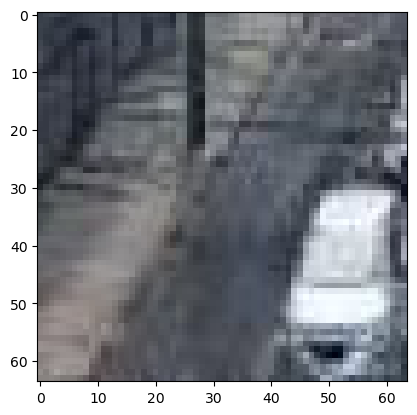

In [139]:
region = region_targets[224]
x = region[3]
y = region[4]
width = region[5]
height = region[6]
cropped_image = image[x - width: x + width, y - height : y + height, :]
cropped_image = np.reshape(cropped_image, (width * 2, height * 2, 3))
print(cropped_image.shape)
cropped_image = cv2.resize(cropped_image, (64, 64))
plt.imshow(cropped_image)

In [140]:
# Defining the algorithm for loading all the images
for i in range(len(images)):
    image, coords = load_image(images, labels, i)
    target_regions = propose_regions(image, coords)
    cropped_image = resize_region(image, target_regions[50])
    plt.imshow(cropped_image)
    break

  0%|          | 0/11532 [00:00<?, ?it/s]

  3%|▎         | 360/11532 [00:02<01:10, 157.57it/s]


KeyboardInterrupt: 

In [18]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, folder, batch_size = 32):
        self.folder = folder
        self.batch_size = batch_size
        self.images = os.listdir(f'{folder}/images')
        self.labels = os.listdir(f'{folder}/labels')
    
    def __len__(self):
        return self.images.__len__()
    
    def __getitem__(self, index):
        X = []
        y = []
        region_ratios = [[1, 1], [2, 1]]
        region_scales = [16, 24, 32, 40]
        image, coords = load_image(images, labels, index)
        target_regions = propose_regions(image, coords, anchor_point_stride=30, region_ratios=region_ratios, region_scales=region_scales)
        for region in target_regions:
            cropped_image = resize_region(image, region)
            X.append(cropped_image)
            y.append(region[0])
        X = np.array(X)
        y = np.array(y)
        return X, y

In [19]:
train_generator = DataGenerator(train_folder, 1)
valid_generator = DataGenerator(valid_folder, 1)

# Model Definition and Training

In [23]:
i = Input(shape=(64, 64, 3))
x = Conv2D(32, (3, 3), activation= 'relu')(i)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(32, (3, 3), activation= 'relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(32, (3, 3), activation= 'relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dense(units=128, activation='relu')(x)
x = Dense(units=1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(loss='binary_crossentropy', optimizer='adam', run_eagerly= True)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 12, 12, 32)        9248

In [21]:
model.fit(train_generator, epochs= 1, steps_per_epoch=len(train_generator), validation_data=valid_generator, validation_steps=len(valid_generator))

  0%|          | 0/3528 [00:00<?, ?it/s]

  0%|          | 0/3528 [00:00<?, ?it/s]

ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 640, 640, 3), found shape=(2981, 64, 64, 3)

100%|██████████| 3528/3528 [01:53<00:00, 31.06it/s]
